<a href="https://colab.research.google.com/github/vale314/Segmentention-Brain/blob/test/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer 

import nibabel as nib
import pandas as pd
import numpy as np #importando numpy
from scipy import stats # importando scipy.stats
import matplotlib.pyplot as plt # importando matplotlib
import seaborn as sns # importando seaborn
import seaborn as sb
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
# Graficos embebidos.
%matplotlib inline

In [6]:
# Trabajando con una ruta relativa
path = './drive/MyDrive/Dataset/' 

# Colocamos en una variable el archivo a trabajar
archivo = 'participants.csv'

In [7]:
# Paquete requerido para listar los archivos del directorio
from os import listdir

In [8]:
Files = []
for File in listdir(path):
    # Escribir la RUTA COMPLETA de cada archivo
    Files.append(File)

In [9]:
Files

['anat',
 'participants.json',
 'dataset_description.json',
 'participants.tsv',
 'participants.csv',
 'masks']

In [10]:
# Archivos propios JUAN Y VALENTIN
IMG_PATH = './drive/MyDrive/Dataset/anat/'
MASK_PATH = './drive/MyDrive/Dataset/mask/'
OUTPUT_PATH = './drive/MyDrive/Dataset/output/'
DF_PATH = './drive/MyDrive/Dataset/participants.tsv'

In [11]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max-min)
    # volume[volume < min] = min
    # volume[volume > max] = max
    # volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    
    # Resize width, height and depth
    volume = resize_volume(volume)
    
    # Normalize
    volume = normalize(volume)
    
    return volume

In [12]:
HC_ID = 1 #sano
CUD_ID = 2 #coco

# Lectura de archivo tsv
df = pd.read_table(DF_PATH)

#Lectura de la ruta de los archivos
cud_filenames = df[df.group==CUD_ID].participant_id.values
hc_filenames = df[df.group==HC_ID].participant_id.values

cud_filenames = sorted(cud_filenames)

hc_filenames = sorted(hc_filenames)

cud_filenames = cud_filenames[0:64]

print("MRI scans with normal brain: " + str(len(hc_filenames)))
print("MRI scans with abnormal brain: " + str(len(cud_filenames)))


MRI scans with normal brain: 64
MRI scans with abnormal brain: 64


In [13]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(IMG_PATH + path + '_T1w.nii.gz') for path in cud_filenames])
normal_scans = np.array([process_scan(IMG_PATH +path + '_T1w.nii.gz') for path in hc_filenames])

In [14]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:44], normal_scans[:44]), axis=0)
y_train = np.concatenate((abnormal_labels[:44], normal_labels[:44]), axis=0)

x_val = np.concatenate((abnormal_scans[44:], normal_scans[44:]), axis=0)
y_val = np.concatenate((abnormal_labels[44:], normal_labels[44:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 88 and 40.


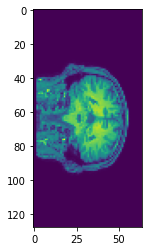

In [15]:
plt.imshow(x_train[0][90,:,:])

In [16]:
x_train[9].min(), x_train[0].max(), x_train[0].shape

(0.0, 1.0, (128, 128, 64))

#Realizar el movimiento de las imagenes en los diferentes planos

In [17]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [18]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the MRI scan is: (128, 128, 64, 1)


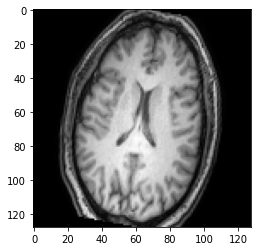

In [19]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

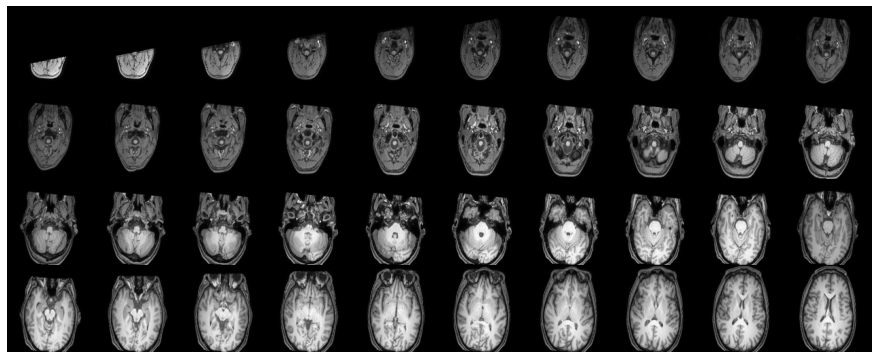

In [53]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the MRI scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [5]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [57]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
44/44 - 33s - loss: 0.5806 - acc: 0.7500 - val_loss: 0.7753 - val_acc: 0.4750 - 33s/epoch - 753ms/step
Epoch 2/50
44/44 - 15s - loss: 0.5986 - acc: 0.7045 - val_loss: 0.9368 - val_acc: 0.4750 - 15s/epoch - 344ms/step
Epoch 3/50
44/44 - 16s - loss: 0.5822 - acc: 0.6932 - val_loss: 1.0908 - val_acc: 0.5000 - 16s/epoch - 364ms/step
Epoch 4/50
44/44 - 15s - loss: 0.5618 - acc: 0.7045 - val_loss: 0.8689 - val_acc: 0.5500 - 15s/epoch - 340ms/step
Epoch 5/50
44/44 - 15s - loss: 0.5781 - acc: 0.7273 - val_loss: 0.8480 - val_acc: 0.5250 - 15s/epoch - 344ms/step
Epoch 6/50
44/44 - 15s - loss: 0.5688 - acc: 0.6477 - val_loss: 0.9042 - val_acc: 0.6000 - 15s/epoch - 343ms/step
Epoch 7/50
44/44 - 15s - loss: 0.5999 - acc: 0.7045 - val_loss: 1.0263 - val_acc: 0.5250 - 15s/epoch - 341ms/step
Epoch 8/50
44/44 - 15s - loss: 0.5542 - acc: 0.7386 - val_loss: 0.8961 - val_acc: 0.5000 - 15s/epoch - 342ms/step
Epoch 9/50
44/44 - 16s - loss: 0.5478 - acc: 0.7273 - val_loss: 0.9325 - val_acc: 0.6250

##Prediction Model

In [91]:
pred = model.predict(np.expand_dims(x_val[3], axis=0))[0]

1/1 [==============================] - 0s 29ms/step


In [93]:
scores = (1 - pred[0], pred[0])

class_name = ("hc", "cud")


for score, name in zip(scores, class_name):  

  print(score, name)

0.2460949420928955 hc
0.75390506 cud


In [21]:
def name_class_test(pred):
  scores = (1 - pred[0], pred[0])

  class_name = ("hc", "cud")

  act = 0
  actmax = 0

  for score, name in zip(scores, class_name):  
    if score > actmax:
      actmax = score
      act = 0 if name == "hc" else 1;

  return(act)

In [22]:
from operator import itemgetter

In [23]:
y_pred = []
for idx in range(len(x_val)):
  pred = model.predict(np.expand_dims(x_val[idx], axis=0))[0]
  y_pred.append(name_class_test(pred))

1/1 [==============================] - 0s 20ms/step


In [25]:
confusion = tf.math.confusion_matrix(labels=y_val, predictions=y_pred)

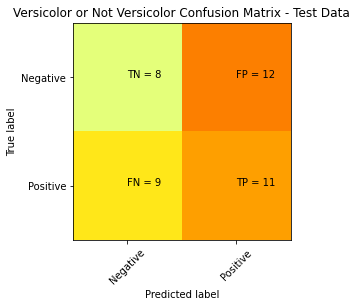

In [48]:
plt.clf()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
confusion_array = confusion.numpy()
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_array[i][j]))
plt.show()

In [52]:
# Accuracy
from sklearn.metrics import accuracy_score
accuray = accuracy_score(y_val, y_pred)

# Recall
from sklearn.metrics import recall_score
reccall = recall_score(y_val, y_pred, average=None)

# Precision
from sklearn.metrics import precision_score
precision_score = precision_score(y_val, y_pred, average=None)

print(accuray, reccall[1], precision_score[1])

0.475 0.55 0.4782608695652174


In [20]:
model = tf.keras.models.load_model('/content/3d_image_classification.h5')